In [1]:
# For my project, I want to build a model that transforms a given sentace to sound like a former US president. 
# Steps...
# pre process my data: I am using a dataset from kaggle which contains presidential inaguaral adresses from president George Washington to president Donald Trump's first term. 

In [2]:
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import random
import textstat

In [3]:
# pre processing
# load my data set

# have to use latin1 because 'utf-8' codec can't decode byte 0xa0 in position 202: invalid start byte
df = pd.read_excel("prez_data.xlsx") 

df.head() # i have name, inaugural address, date, and text
print(len(df))

60


In [4]:
df['President'] = df['Name']
speeches = df.groupby('President')['Text'].apply(lambda x: ' '.join(x)).reset_index()

In [5]:
# start cleaning
def clean(t):
    t = t.lower() # lower case
    t = re.sub(r'[-]', ' ', t) # replace '-' with white spaces
    t = re.sub(r'[^\w\s.,!?;:]', '', t) # keep puncuation                       #t = re.sub(r'[^a-z\s]', '', t) # no special chars
    t = re.sub(r'\s+', ' ', t) # only 1 space 
    t = re.sub(r'<U\+0097>', ' ', t) # weird characters i noticed, replace it with a space
    return t.strip()

speeches['clean'] = speeches['Text'].apply(clean) # apply it

# tokenzie 
def tokenize(t):
    return nltk.word_tokenize(t)

# segment
def segment(t):
    return [ s.strip() for s in re.split(r'[.!?]', t) if s.strip()]

In [6]:
for value in df['Text']:
        print(value)

Fellow-Citizens of the Senate and of the House of Representatives: AMONG the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order, and received on the day of the present month. On the one hand, I was summoned by my country, whose voice I can never hear but with veneration and love, from a retreat which I had chosen with the fondest predilection, and, in my flattering hopes, with an immutable decision, as the asylum of my declining years a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination, and of frequent interruptions in my health to the gradual waste committed on it by time. On the other hand, the magnitude and difficulty of the trust to which the voice of my country called me, being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his qualifications, could not but overwhe

In [7]:
# use tokenization 
speeches['tokens'] = speeches['clean'].apply(tokenize)

In [8]:
print(speeches['tokens'])

0     [fellow, citizens, of, the, united, states, :,...
1     [fellow, citizens, :, about, to, undertake, th...
2     [my, fellow, citizens, :, i, stand, here, toda...
3     [fellow, citizens, :, there, is, no, constitut...
4     [my, fellow, citizens, :, today, we, celebrate...
5     [my, countrymen, :, no, one, can, contemplate,...
6     [chief, justice, roberts, ,, president, carter...
7     [my, friends, ,, before, i, begin, the, expres...
8     [i, am, certain, that, my, fellow, americans, ...
9     [my, countrymen, :, it, a, relief, to, feel, t...
10    [mr., chief, justice, ,, mr., president, ,, vi...
11    [president, clinton, ,, distinguished, guests,...
12    [fellow, citizens, of, the, senate, and, of, t...
13    [fellow, citizens, :, in, the, presence, of, t...
14    [mr., vice, president, ,, mr., chief, justice,...
15    [my, countrymen, :, this, occasion, is, not, a...
16    [fellow, citizens, :, we, stand, to, day, upon...
17    [fellow, citizens, :, i, appear, before, y

In [9]:
# building the president's vocabs TF IDF
top_w = {}

for _, row in speeches.iterrows(): # iterating over speeches
    j = ' '.join(row['tokens']) # taking the tokens and putting back  into string
    vectz = TfidfVectorizer(stop_words='english')  
    v = vectz.fit_transform([j])
    score = {}
    for w in j.split():
        if w in vectz.vocabulary_:
            score[w] = v[0, vectz.vocabulary_[w]]
    sorted_score = sorted(score.items(), key=lambda x: x[1], reverse=True)
    top_w[row['President']] = pd.DataFrame(sorted_score, columns = ['Word(s)', 'TF-IDF Score'])
    
    #print(row['President'])
    #print("\ttop TF-IDF terms:", sorted_score[:10])

In [10]:
# lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(t):
    return[lemmatizer.lemmatize(w) for w in t]

# apply it
speeches['tokens'] = speeches['tokens'].apply(lambda t: [lemmatizer.lemmatize(w) for w in t])

In [11]:
top_w

{'Abraham Lincoln':           Word(s)  TF-IDF Score
 0           union      0.287101
 1    constitution      0.263176
 2           shall      0.263176
 3          people      0.239251
 4          states      0.227288
 ..            ...           ...
 987        battle      0.011963
 988         widow      0.011963
 989        orphan      0.011963
 990       achieve      0.011963
 991       lasting      0.011963
 
 [992 rows x 2 columns],
 'Andrew Jackson':         Word(s)  TF-IDF Score
 0    government      0.366539
 1        people      0.250790
 2        public      0.212207
 3        states      0.192915
 4         union      0.192915
 ..          ...           ...
 663     inspire      0.019292
 664      hearts      0.019292
 665   preserved      0.019292
 666       kinds      0.019292
 667     forever      0.019292
 
 [668 rows x 2 columns],
 'Barack Obama':          Word(s)  TF-IDF Score
 0         nation      0.226044
 1         people      0.226044
 2            new      0.2134

In [12]:
# my rewriter using TF IDF 
def rewrite(Input, president):
    if president not in top_w:
        return "Pick a different President!" # quick check! it's case sensitive so it will display this message if not written the exact way
        
    tokens = tokenize(clean(Input)) # the user input must also be cleaned and tokenized 
    vocab = top_w[president]
    top_words = vocab['Word(s)'].tolist() # based on the president, pick their top words

    # add back punc
    rew = []
    for w in tokens:
        if w.isalpha() and len(w) > 3 and random.random() < 0.50: # 50% of the time words will be replaced
            rew.append(random.choice(top_words))
        else:
            rew.append(w)  # keep punctuation 
    return " ".join(rew).replace(" ,", ",").replace(" .", ".").replace(" !", "!").replace(" ?", "?")

In [13]:
def rewrite_pos(Input, president):
    if president not in top_w:
        return "Pick a different President!" # quick check again
        
    tokens = nltk.word_tokenize(clean(Input)) # clean & tokenize 
    tagged = nltk.pos_tag(tokens, tagset='universal') # tag each word based on POS
    
    vocab = top_w[president]
    top_words = vocab['Word(s)'].tolist()
    prez_w = [w for w in top_words if w.isalpha()]
    prez_tagged = nltk.pos_tag(prez_w, tagset='universal')
    
    pos_dict = {}
    for w, tag in prez_tagged:
        pos_dict.setdefault(tag, []).append(w) # group them 

    rew = [] # rew is for my rewritten sentances 
    content_tags = {"NOUN", "VERB", "ADJ", "ADV"}
    for w, tag in tagged:
        if (
            w.isalpha() and 
            tag in content_tags and tag in pos_dict and len(w) > 3 and random.random() < 0.5):
            rew.append(random.choice(pos_dict[tag])) 
        else:
            rew.append(w)

    return " ".join(rew).replace(" ,", ",").replace(" .", ".").replace(" !", "!").replace(" ?", "?")

In [14]:
# analysis
def Lmetrics(tokens):
    total = len(tokens) # total words
    unique = len(set(tokens)) # unique words 
    
    return pd.Series({
        'totalWords': total,
        'uniqueWords': unique,
        'ttr': unique / total if total else 0, 
    })


In [15]:
mets = speeches['tokens'].apply(Lmetrics) # apply metrics 
mets['President'] = speeches['President']

In [16]:
def avgSentLen(t): # this is for my future plotting
    sentences = re.split(r'[.!?]', t) # putting common puncutation 
    sentences = [s for s in sentences if s.strip()] # no empty spaces 
    wc = [len(tokenize(s)) for s in sentences] # using tokenize to sount the words in each sentance 
    return sum(wc) / len(wc) if sentences else 0 # calcuating the average 

speeches['avg_sentence_length'] = speeches['clean'].apply(avgSentLen) # new column!


In [17]:
# mets = speeches[['President', 'avg_sentence_length']] 

In [18]:
# recalc the metrics
L = speeches['tokens'].apply(Lmetrics)
L['President'] = speeches['President']

# i want the avg sentance lengths
slen = speeches[['President', 'avg_sentence_length']]

# merge on president
ttrAndLen = pd.merge(L, slen, on='President')


In [19]:
ttrAndLen = ttrAndLen.sort_values(by='ttr', ascending=True)
ttrAndLen

,totalWords,uniqueWords,ttr,President,avg_sentence_length
20,8571.0,1574.0,0.183643,James Monroe,32.488281
35,5956.0,1257.0,0.211048,William Henry Harrison,40.685315
28,4322.0,948.0,0.219343,Richard Milhous Nixon,23.451977
36,5827.0,1291.0,0.221555,William Howard Taft,35.425000
37,6767.0,1523.0,0.225063,William McKinley,28.421739
8,6101.0,1415.0,0.231929,Franklin D. Roosevelt,20.800000
29,5609.0,1302.0,0.232127,Ronald Reagan,20.755814
18,5153.0,1200.0,0.232874,James Knox Polk,32.679739
0,4748.0,1118.0,0.235468,Abraham Lincoln,28.490683
6,4959.0,1178.0,0.237548,Donald J. Trump,17.120438


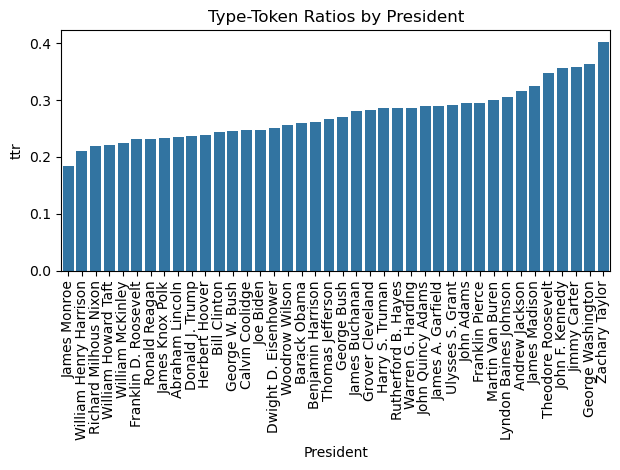

In [20]:
sns.barplot(data=ttrAndLen.sort_values('ttr'), x='President', y='ttr')
plt.title('Type-Token Ratios by President')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

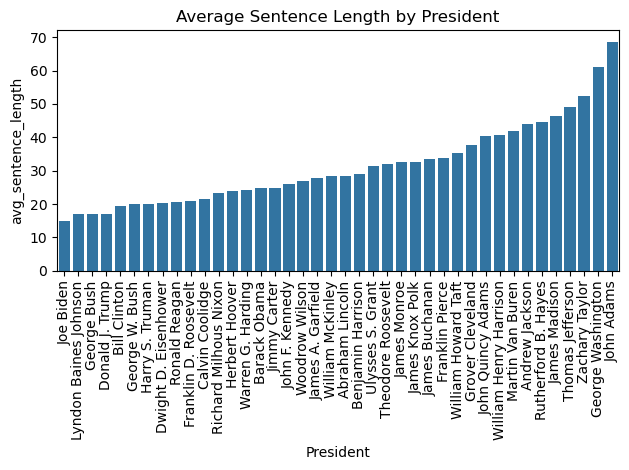

In [21]:
sns.barplot(data=ttrAndLen.sort_values('avg_sentence_length'), x='President', y='avg_sentence_length')
plt.title('Average Sentence Length by President')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
print(ttrAndLen.sort_values('ttr'))

    totalWords  uniqueWords       ttr               President  \
20      8571.0       1574.0  0.183643            James Monroe   
35      5956.0       1257.0  0.211048  William Henry Harrison   
28      4322.0        948.0  0.219343   Richard Milhous Nixon   
36      5827.0       1291.0  0.221555     William Howard Taft   
37      6767.0       1523.0  0.225063        William McKinley   
8       6101.0       1415.0  0.231929   Franklin D. Roosevelt   
29      5609.0       1302.0  0.232127           Ronald Reagan   
18      5153.0       1200.0  0.232874         James Knox Polk   
0       4748.0       1118.0  0.235468         Abraham Lincoln   
6       4959.0       1178.0  0.237548         Donald J. Trump   
15      4071.0        970.0  0.238271          Herbert Hoover   
4       4200.0       1026.0  0.244286            Bill Clinton   
11      4110.0       1008.0  0.245255          George W. Bush   
5       4439.0       1100.0  0.247804         Calvin Coolidge   
22      2970.0        736

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2613013502.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


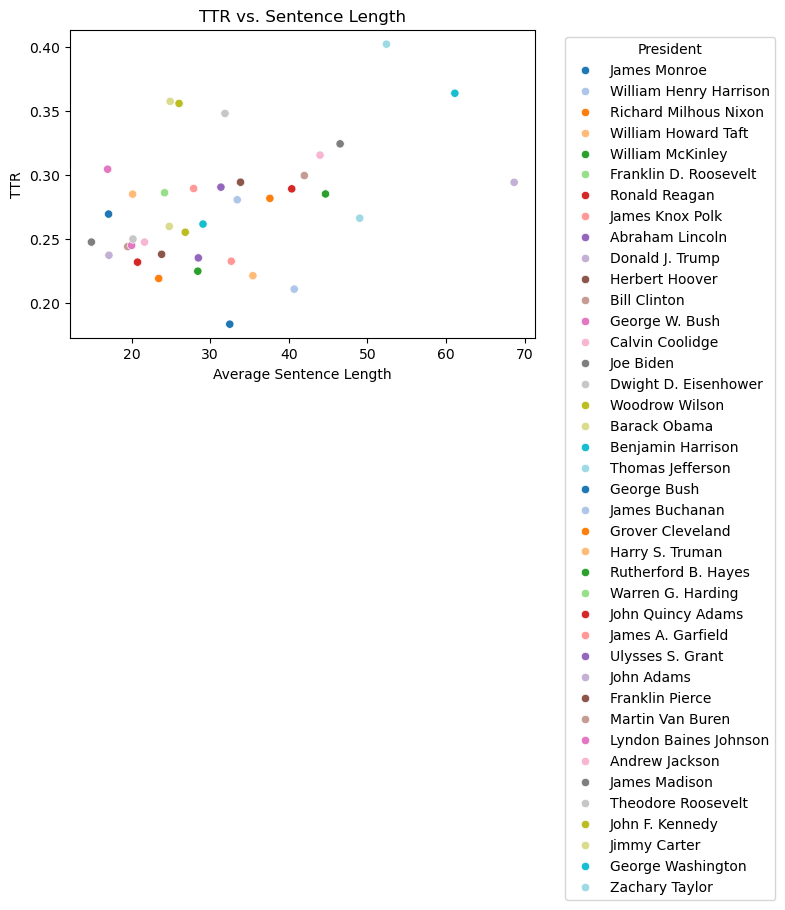

In [23]:
plt.figure(figsize=(6, 4))
sns.set_palette("tab20", n_colors=len(ttrAndLen['President'].unique())) # more different colors
sns.scatterplot(data=ttrAndLen, x='avg_sentence_length', y='ttr', hue='President', legend=True)
plt.title("TTR vs. Sentence Length")
plt.xlabel("Average Sentence Length")
plt.ylabel("TTR")
plt.legend(title='President', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


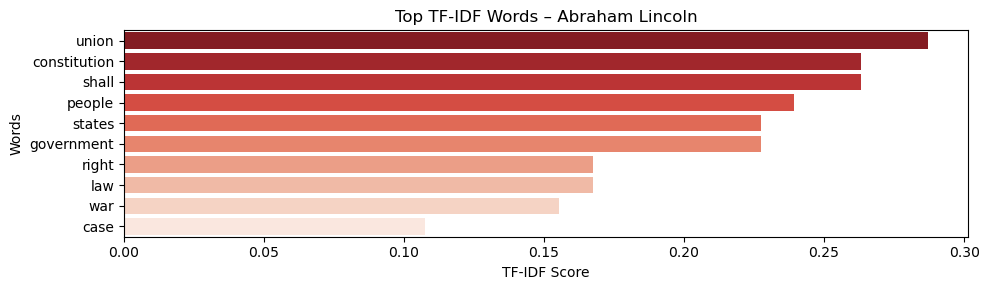

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


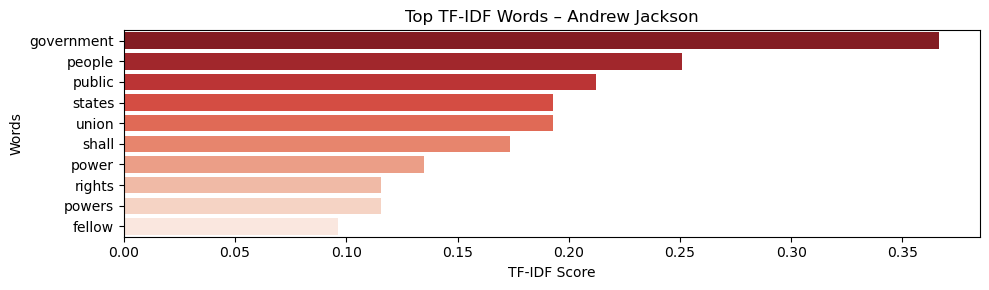

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


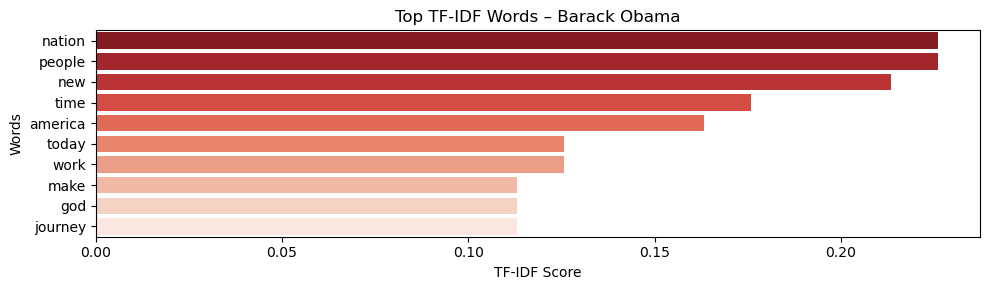

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


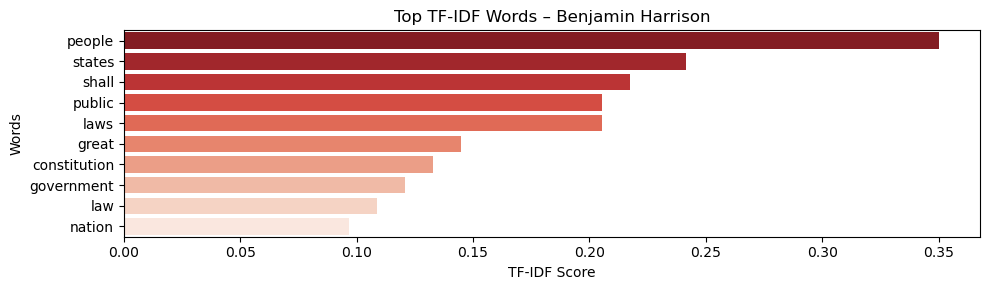

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


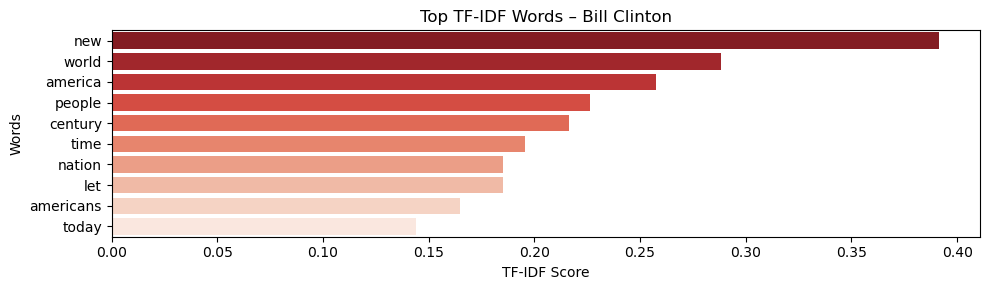

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


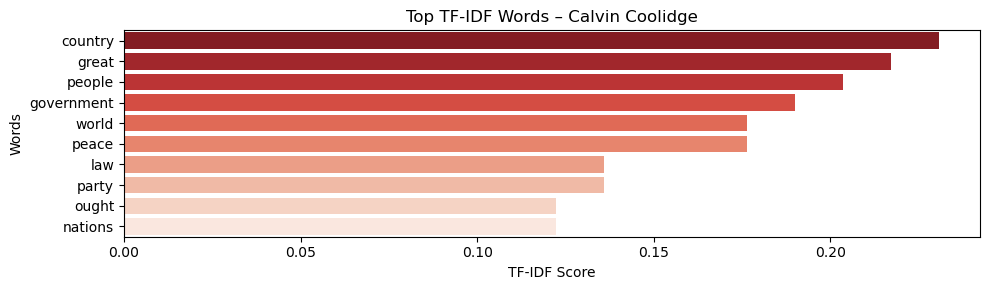

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


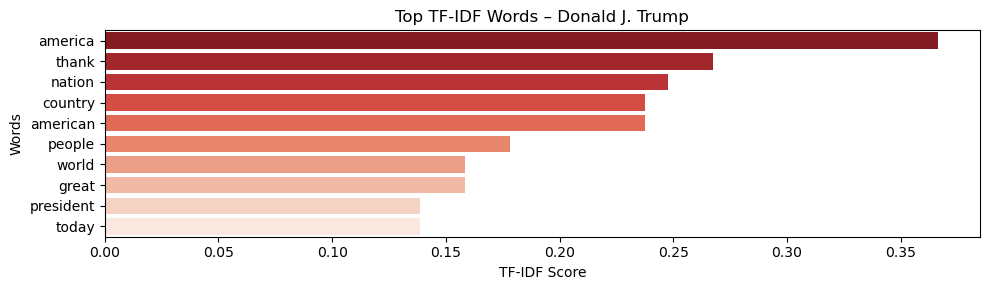

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


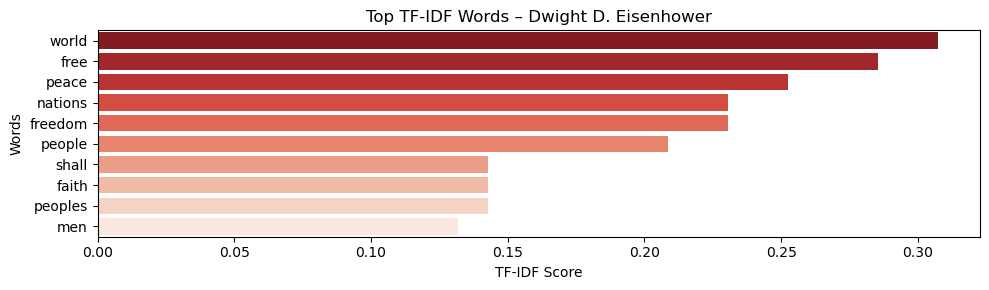

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


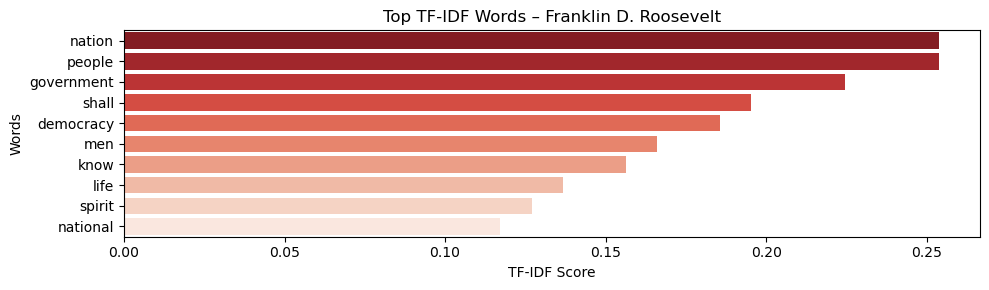

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


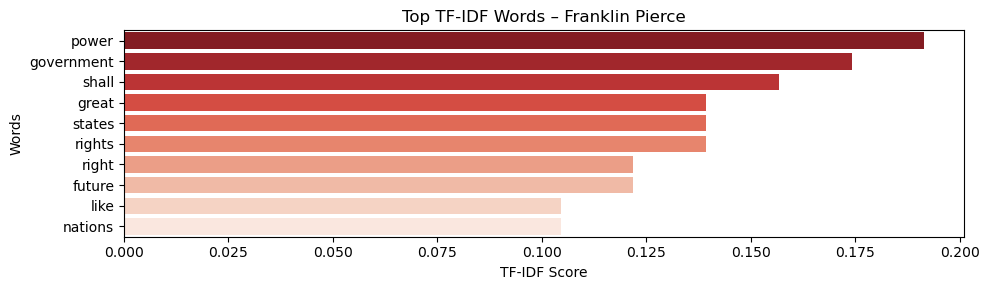

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


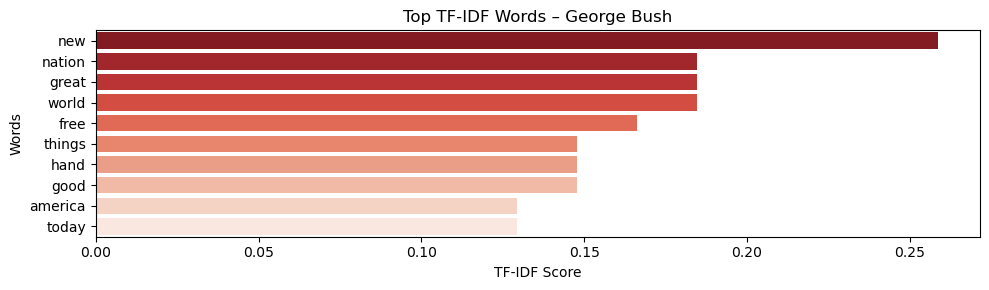

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


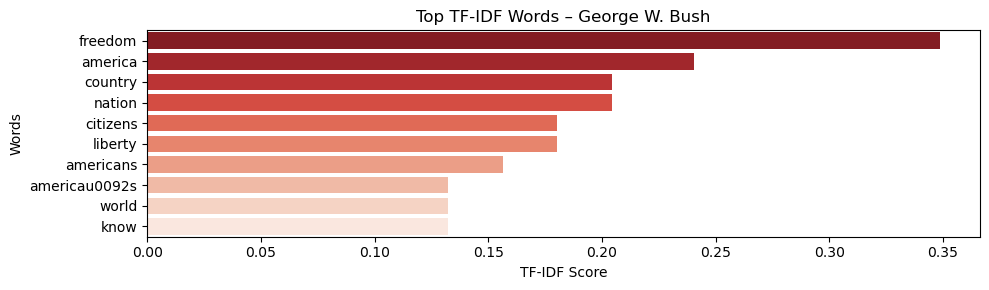

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


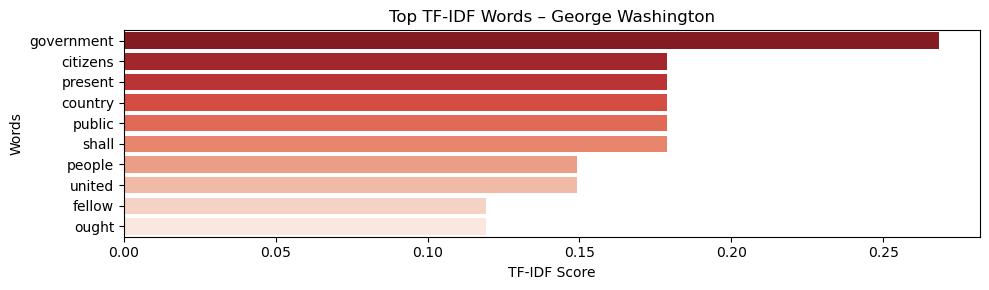

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


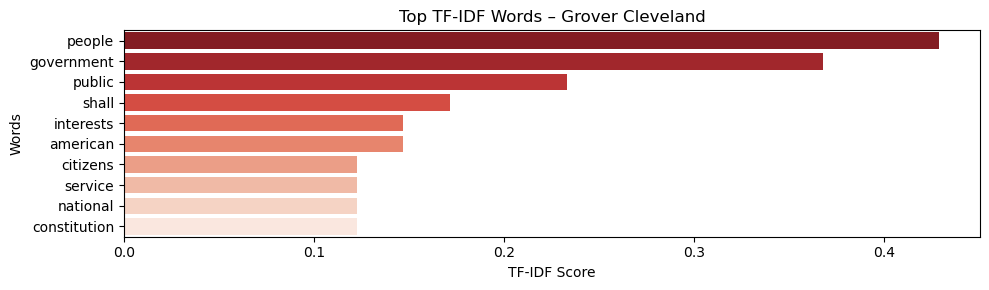

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


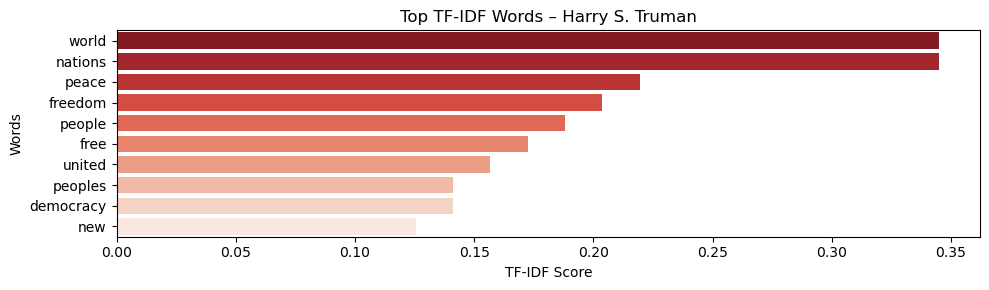

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


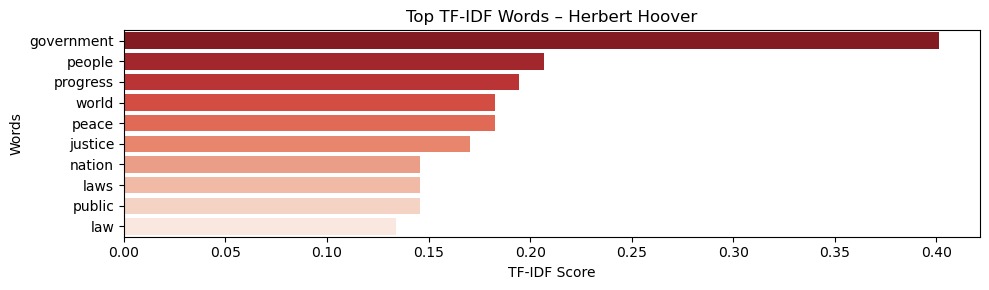

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


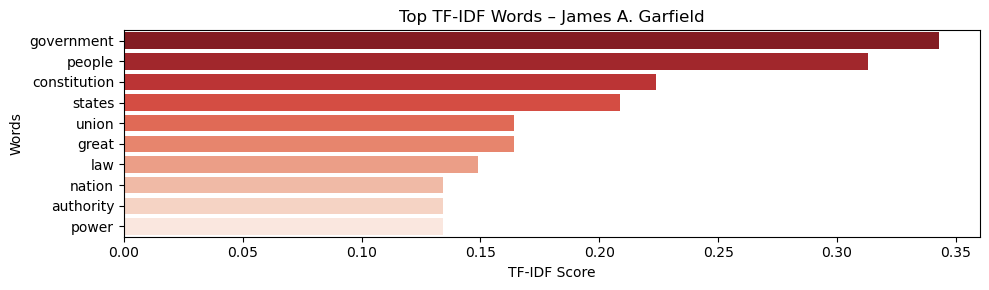

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


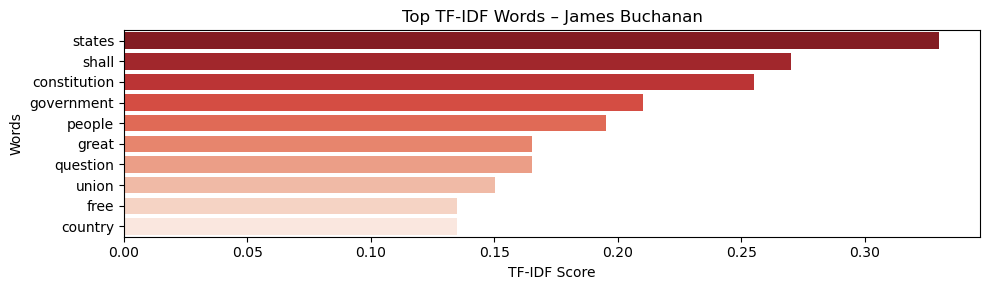

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


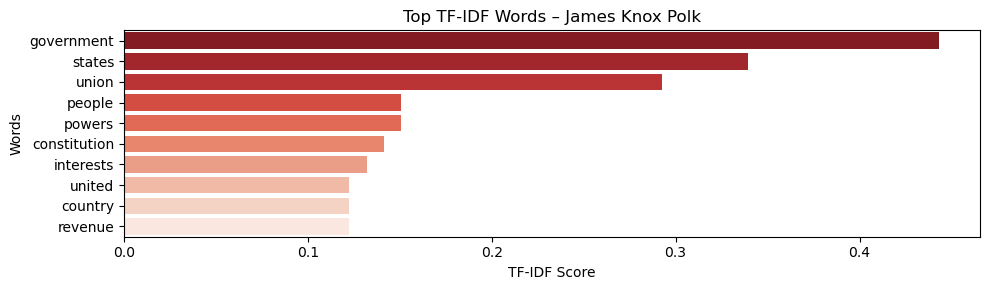

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


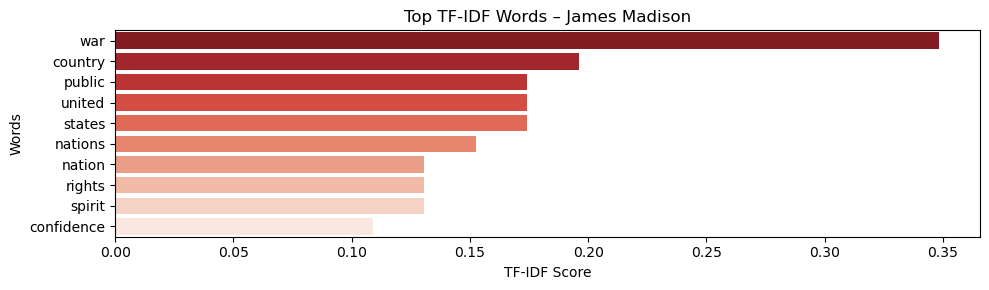

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


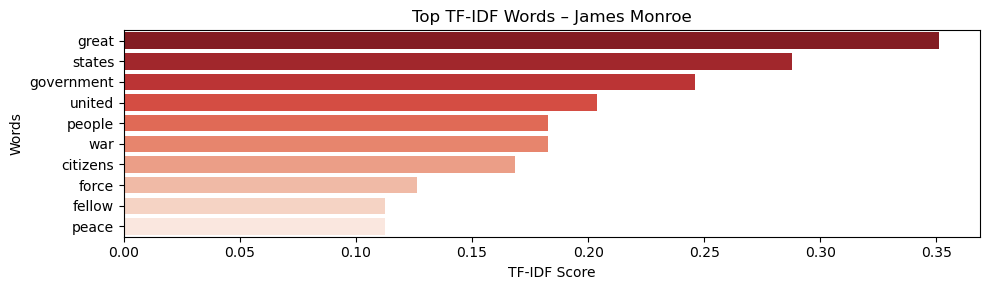

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


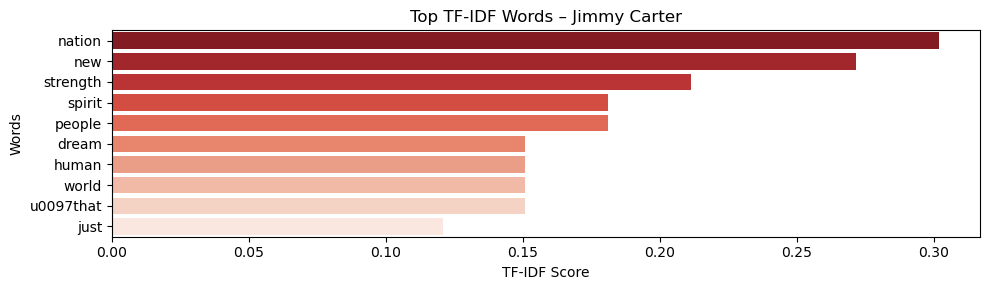

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


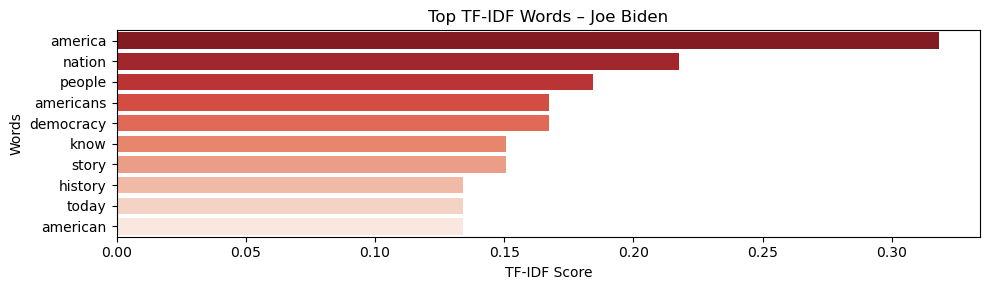

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


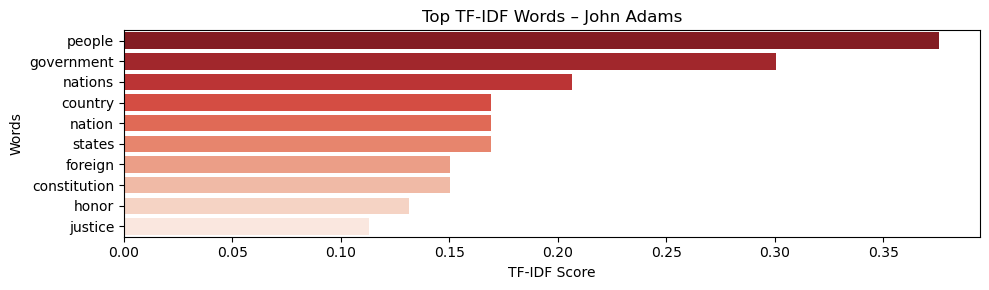

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


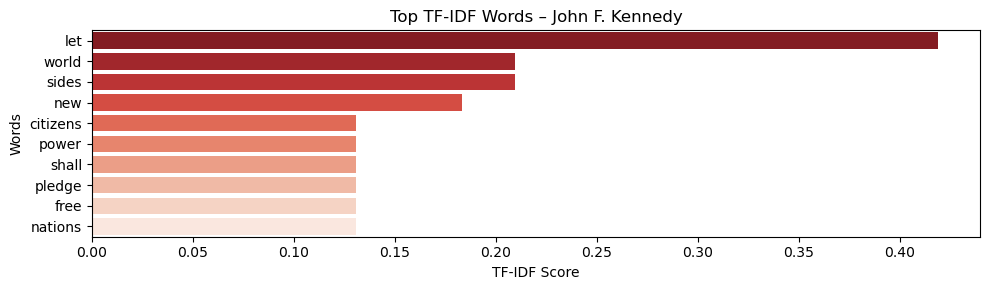

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


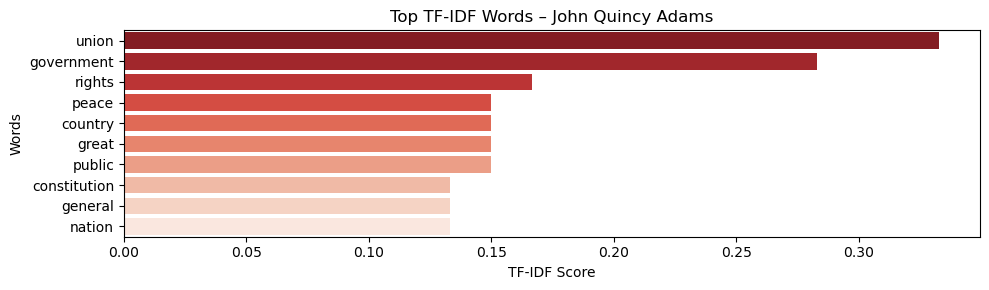

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


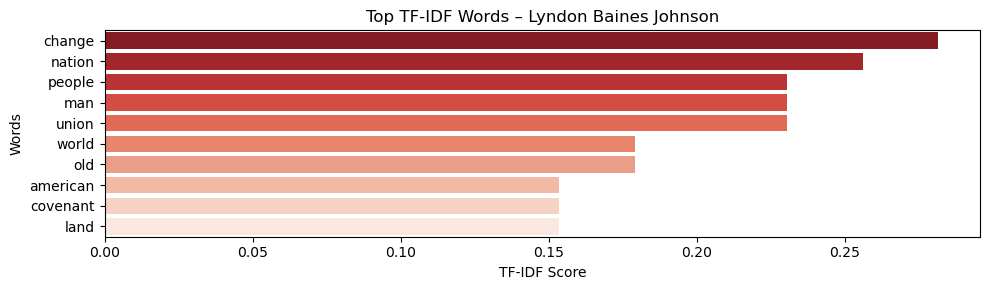

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


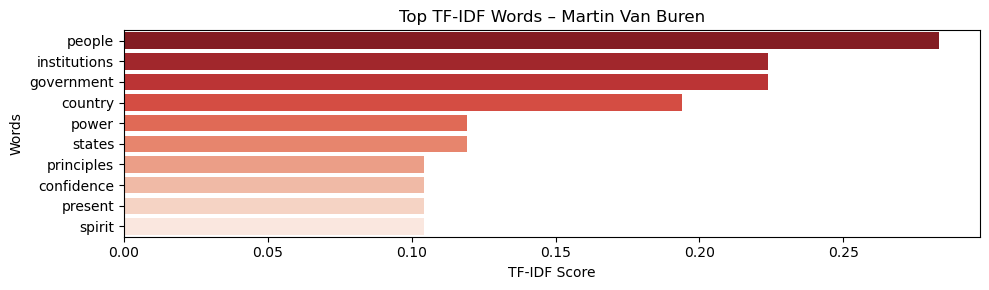

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


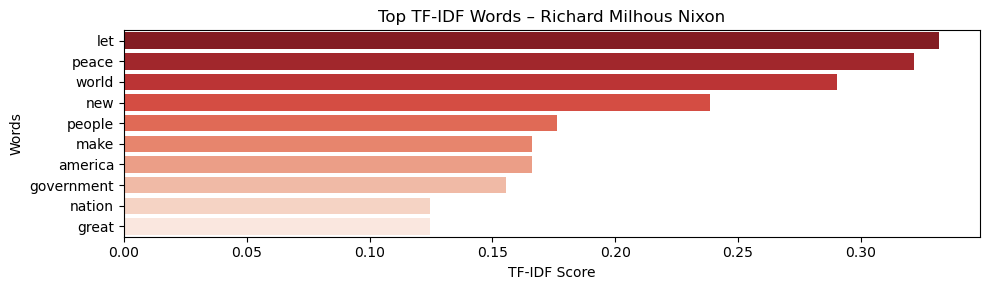

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


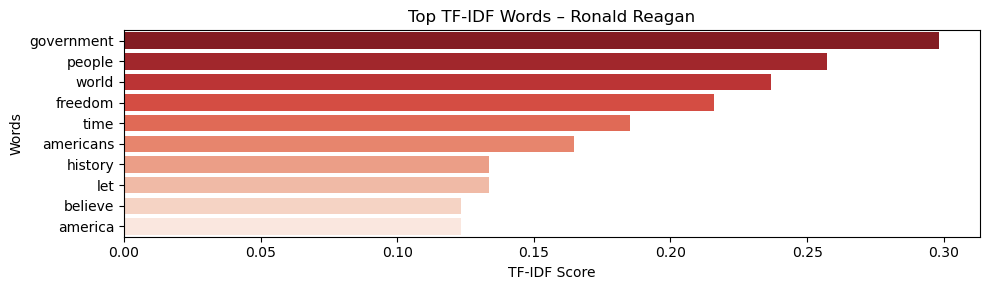

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


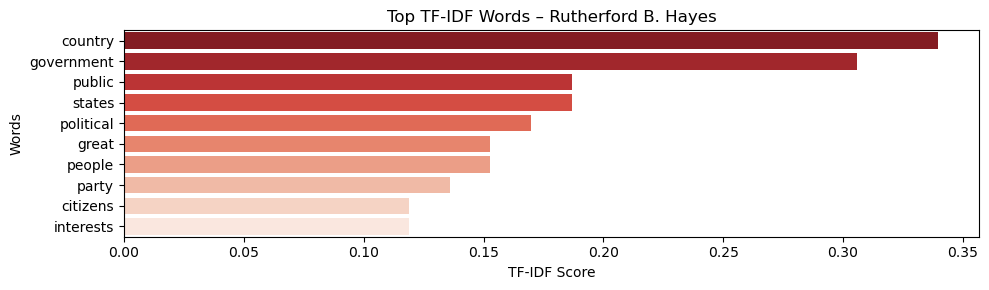

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


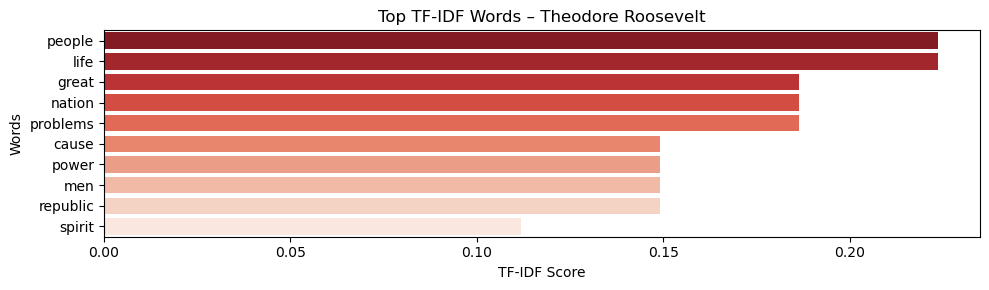

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


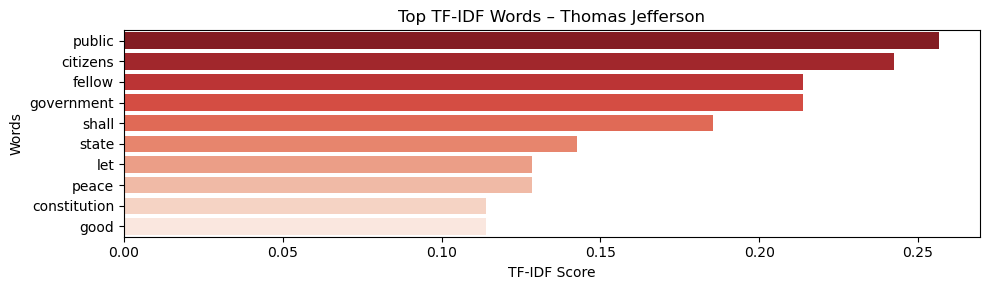

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


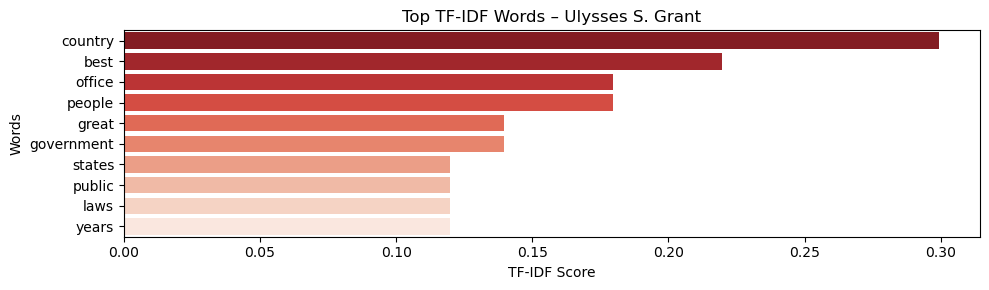

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


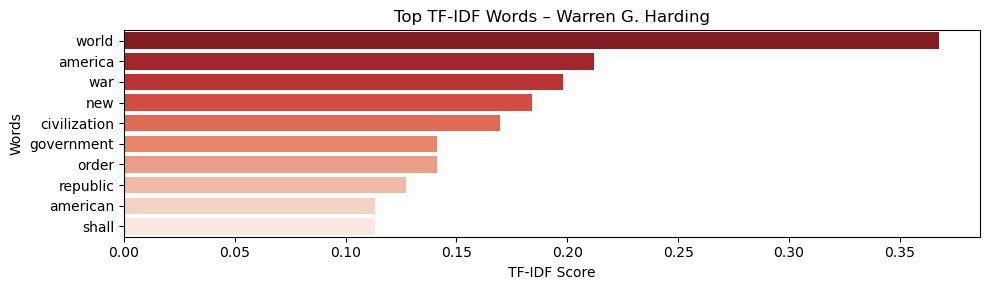

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


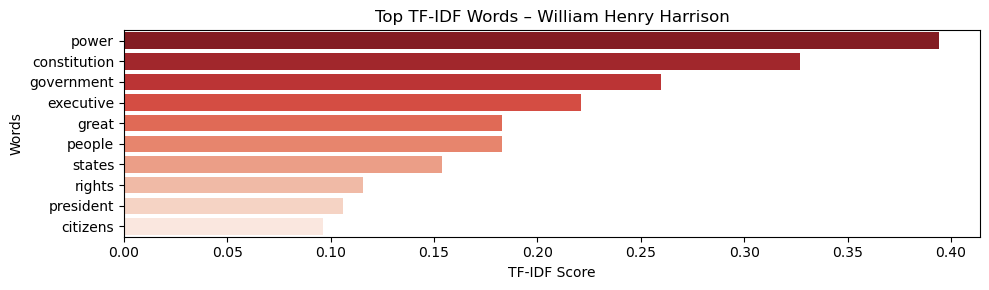

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


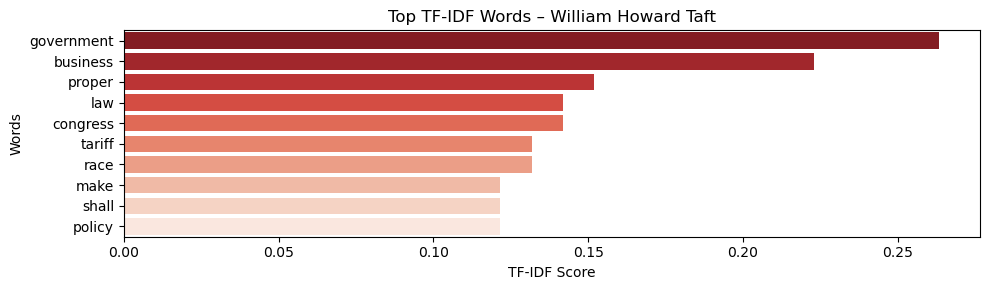

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


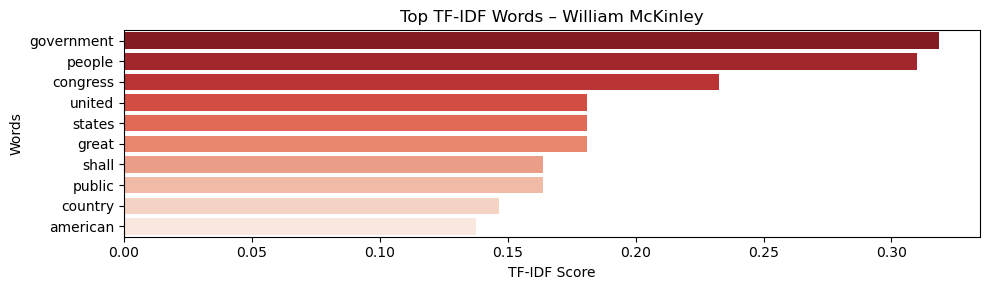

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


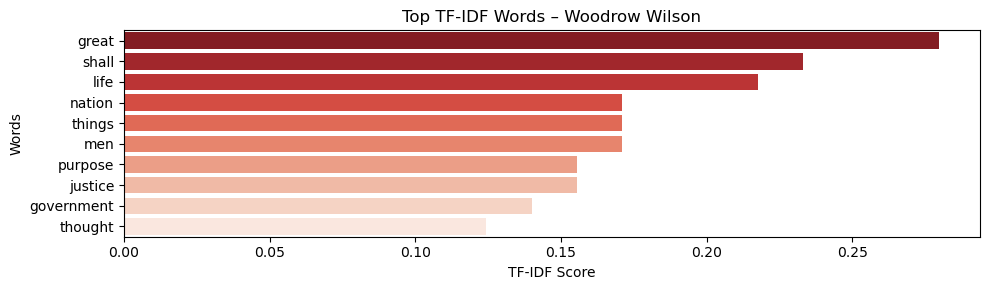

/var/folders/c2/nh0qq0ld2q155sv29jq38y780000gn/T/ipykernel_7661/2291779359.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')


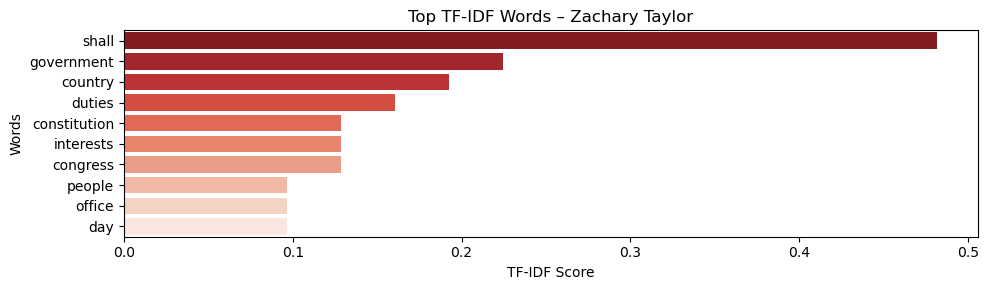

In [24]:
 for president, df in top_w.items():
     plt.figure(figsize=(10, 3))
     sns.barplot(data=df.head(10), x='TF-IDF Score', y='Word(s)', palette='Reds_r')
     plt.title(f"Top TF-IDF Words – {president}")
     plt.xlabel("TF-IDF Score")
     plt.ylabel("Words")
     plt.tight_layout()
     plt.show()
# df.loc[df['column_name'] == 'desired_value'].iloc[0]

In [25]:
print(mets.columns)

Index(['totalWords', 'uniqueWords', 'ttr', 'President'], dtype='object')


In [26]:
# rewrite 
def TalkLikeAPrez():
    print("Pick a President (case sensitive):") # the different presidents in the dataset 
    for name in sorted(top_w.keys()):
        print("*", name)
    prezPick = input("\nEnter a President's name: ").strip() #user input
    sentanceRew = input("Enter what you would like to be rewritten: ").strip() # user input 
    print("\n[Rewriter]") # first rewriter 
    print(rewrite(sentanceRew, prezPick))
    print("\n[POS Rewriter]") # POS rewriter 
    print(rewrite_pos(sentanceRew, prezPick))

In [ ]:
TalkLikeAPrez()

Pick a President (case sensitive):
* Abraham Lincoln
* Andrew Jackson
* Barack Obama
* Benjamin Harrison
* Bill Clinton
* Calvin Coolidge
* Donald J. Trump
* Dwight D. Eisenhower
* Franklin D. Roosevelt
* Franklin Pierce
* George Bush
* George W. Bush
* George Washington
* Grover Cleveland
* Harry S. Truman
* Herbert Hoover
* James A. Garfield
* James Buchanan
* James Knox Polk
* James Madison
* James Monroe
* Jimmy Carter
* Joe Biden
* John Adams
* John F. Kennedy
* John Quincy Adams
* Lyndon Baines Johnson
* Martin Van Buren
* Richard Milhous Nixon
* Ronald Reagan
* Rutherford B. Hayes
* Theodore Roosevelt
* Thomas Jefferson
* Ulysses S. Grant
* Warren G. Harding
* William Henry Harrison
* William Howard Taft
* William McKinley
* Woodrow Wilson
* Zachary Taylor


In [ ]:
# using flesch method to see how easy something is to read

text = "hi cds 321 class! waste is my enable. lets see how it does."

flesch_score = textstat.flesch_reading_ease(text)
grade_level = textstat.flesch_kincaid_grade(text)

print(f"Flesch Reading Score: {flesch_score}")
print(f"Flesch Grade Level: {grade_level}")

In [ ]:
# RUN THIS IN YOUR NOTEBOOK
import json

# pick how many top words you want per president (100–300 is plenty)
TOP_N = 200

presidents_vocab = {
    pres: df['Word(s)'].head(TOP_N).tolist()
    for pres, df in top_w.items()
}

with open("presidents_vocab.json", "w", encoding="utf-8") as f:
    json.dump(presidents_vocab, f, ensure_ascii=False, indent=2)
